In [1]:
# Step 1: Install and Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [2]:
#  Step 2: Uploaded the Dataset (animal_classification.zip)

from google.colab import files
uploaded = files.upload()

zip_path = 'animal_classification.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('animal_dataset')

data_dir = 'animal_dataset'


Saving animal_classification.zip to animal_classification.zip


In [10]:
# Step 3: Detect Actual Dataset Folder
root_path = pathlib.Path("animal_dataset")

# Find folder that contains ≥10 subfolders (our classes)
for item in root_path.rglob("*"):
    if item.is_dir():
        subdirs = [x for x in item.iterdir() if x.is_dir()]
        if len(subdirs) >= 10:  # heuristic: ≥10 classes
            data_dir = item
            break

print(f"✅ Dataset directory detected: {data_dir}")

class_names = sorted([x.name for x in data_dir.iterdir() if x.is_dir()])
print(f"Classes detected ({len(class_names)}): {class_names}")


✅ Dataset directory detected: animal_dataset/Animal Classification/dataset
Classes detected (15): ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


In [11]:
#  Step 4: Create Train/Validation Split
base_dir = 'animal_data_split'
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(base_dir + '/train')
os.makedirs(base_dir + '/val')

valid_class_names = []

for class_name in class_names:
    img_paths = list((data_dir/class_name).glob('*'))
    if len(img_paths) == 0:
        print(f"⚠️ Skipping empty class: {class_name}")
        continue
    valid_class_names.append(class_name)

print(f"✅ Classes with data: {valid_class_names}")

for class_name in valid_class_names:
    img_paths = list((data_dir/class_name).glob('*'))
    train_imgs, val_imgs = train_test_split(img_paths, test_size=0.2, random_state=42)

    os.makedirs(f"{base_dir}/train/{class_name}")
    os.makedirs(f"{base_dir}/val/{class_name}")

    for img in train_imgs:
        shutil.copy(str(img), f"{base_dir}/train/{class_name}/")
    for img in val_imgs:
        shutil.copy(str(img), f"{base_dir}/val/{class_name}/")

train_dir = base_dir + '/train'
val_dir = base_dir + '/val'


✅ Classes with data: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


In [12]:
# Step 5: Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 1549 images belonging to 15 classes.
Found 395 images belonging to 15 classes.


In [13]:
#  Step 6: Build Model (Transfer Learning)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE+(3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(valid_class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
#  Step 7: Train Model
EPOCHS = 10

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.3417 - loss: 2.2496 - val_accuracy: 0.8228 - val_loss: 0.6188
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7613 - loss: 0.7852 - val_accuracy: 0.8785 - val_loss: 0.3980
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8491 - loss: 0.5015 - val_accuracy: 0.8886 - val_loss: 0.3685
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8481 - loss: 0.4721 - val_accuracy: 0.9038 - val_loss: 0.3193
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8748 - loss: 0.3707 - val_accuracy: 0.9038 - val_loss: 0.3034
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8956 - loss: 0.3381 - val_accuracy: 0.9038 - val_loss: 0.3089
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9067 - loss: 0.2923 - val_accuracy: 0.9038 - val_loss: 0.3153
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8997 - loss: 0.2919 - val_accuracy: 0.8937 - val_los

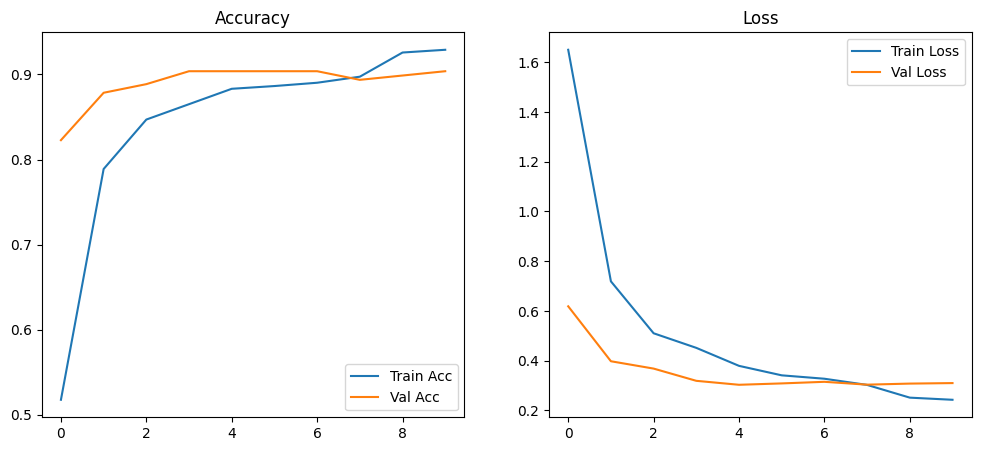

In [15]:
#  Step 8: Plot Training Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
              precision    recall  f1-score   support

        Bear       0.03      0.04      0.03        25
        Bird       0.04      0.04      0.04        28
         Cat       0.10      0.08      0.09        25
         Cow       0.00      0.00      0.00        27
        Deer       0.13      0.15      0.14        26
         Dog       0.06      0.08      0.07        25
     Dolphin       0.15      0.15      0.15        26
    Elephant       0.12      0.11      0.11        27
     Giraffe       0.08      0.08      0.08        26
       Horse       0.08      0.08      0.08        26
    Kangaroo       0.12      0.12      0.12        26
        Lion       0.00      0.00      0.00        27
       Panda       0.13      0.11      0.12        27
       Tiger       0.04      0.04      0.04        26
       Zebra       0.00      0.00      0.00        28

    accuracy                           0.07       395
   macro avg       0.07      0.07      0.

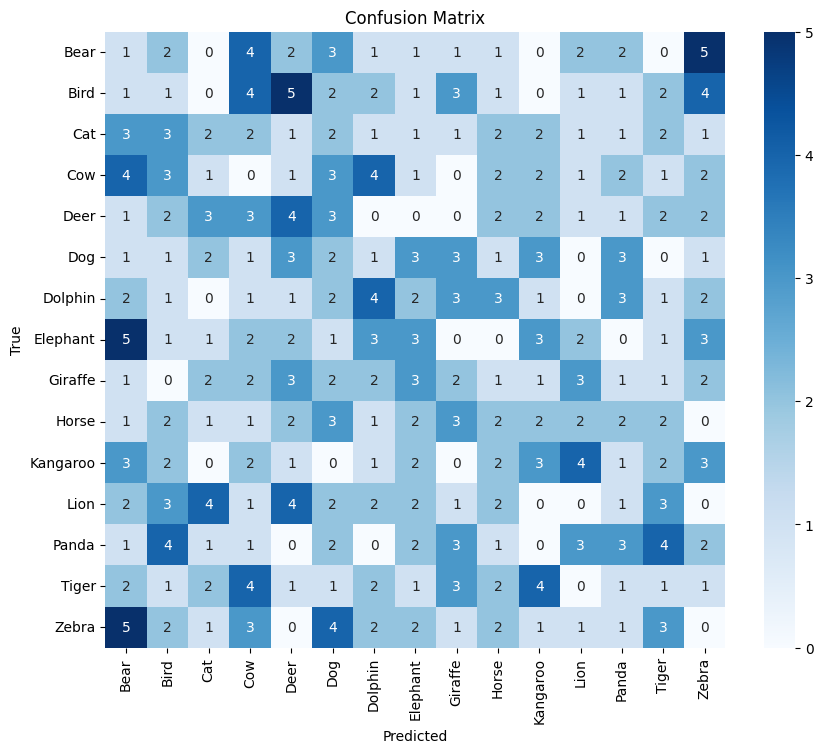

In [17]:
#  Step 9: Evaluate
val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=valid_class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid_class_names, yticklabels=valid_class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
